# Aula 8 - Random Search

Na aula de hoje, vamos explorar os seguintes tópicos em Python

- 1) breve revisão sobre o GridSearch para seleção de hiperparâmetros
- 2) RandomSearch como uma ferramenta alternativa ao GridSearch

_____

# 1) GridSearch (revisão)

Conforme já vimos, o GridSearch é um método proporcionado pelo módulo *scikit-learn* para seleção de hiperparâmetros, representando a **busca exaustiva de hiperparâmetros** de um estimador.

Ele faz isso por meio do treinamento de **diversos modelos com diferentes combinações de hiperparâmetros**, e vai salvando os resultados de desempenho - medidos por um *scoring*. Ao final do processo, a melhor combinação (aquela com o melhor valor da métrica) de hiperparâmetros é selecionada. O *scikit-learn* ainda apresenta a possibilidade de fazer essa avaliação usando validação cruzada - GriSearchCV, o que aumenta a robustez estatística e a confiabilidade dos resultados obtidos.

Para encontrar mais informações sobre os *scorings* utilizados, você pode usar o [LINK](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

Para utilizar quaisquer umas das técnicas, devemos informar a grade.

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

O argumento mais comum de ser passado ao GridSearchCV é o **Pipeline**, onde podemos agrupar várias operações sequenciais sobre os dados. Mais informações podem ser checadas [nesse link](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

________

# 2) Random Search

O GridSearch é um excelente método para buscar hiperparâmetros de um estimador, mas tem dois principais pontos fracos:

- E se a combinação "ótima" de hiperparâmetros não estiver dentro da grade especificada? Nesse caso, o GridSearch vai chegar numa solução boa, mas não podemos garantir de fato que ela seja a melhor, visto que ele nunca vai estar olhando para a região correta.
- Para resolver a questão anterior, e se nós aumentássemos a grade informada para "cobrir uma área maior"? Nesse caso teríamos um problema de *explosão combinatória*. Vejamos um caso de dois hiperparâmetros de caráter contínuo:
    - Se cada um deles assumir 5 valores, temos 25 experimentos (que pode ser multiplicado por 5 ou 10, dependendo do cross validation que usarmos).
    - Se cada um deles assumir 10 valores, esse valor sobe para 100 experimentos
    - Se cada um deles assumir 20 valores, temos 400 experimentos
    - Para 40 valores, 1600.
    - 80 valores, 6400
    - ...
Para uma variável contínua, ela pode assumir infinitos valores, então para garantir matematicamente que vamos encontrar a solução ótima, temos de explorar infinitas possibilidades, algo que não possuímos tempo ou recursos computacionais para conseguir.
- Um terceiro ponto que precisamos ter em mente é mais voltado para o ponto de vista do negócio. Mesmo que algumas combinações sejam exploradas no GridSearch, pode ser que elas nem seja de interesse do negócio. Ainda assim, o método "gasta recursos computacionais" para explorar essas soluções.

É nesse contexto que entra o método de **Random Search** ou Busca Aleatória.

Ao invés de realizar uma busca bruta, onde todas as combinações são exploradas, o RandomSearch realiza uma amostragem aleatória de valores dos hiperparâmetros informados e somente depois realiza as combinações para o experimentador avaliar segundo o scoring.

<img src="https://miro.medium.com/max/1400/1*9W1MrRkHi0YFmBoHi9Y2Ow.png" width=500>

In [15]:
import os
import warnings
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, \
    make_scorer

# ignorar warnings
warnings.filterwarnings('ignore')

# definir uma constante
DATASOURCE = '.'

In [16]:
# realizar a leitura dos dados
data = pd.read_csv(os.path.join(DATASOURCE, 'breast-cancer.csv'))
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
# checando nos tipos dos dados para verificar variáveis categóricas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [18]:
# eliminar a coluna 'ID'
data.drop(['id'], axis = 1, inplace=True)

# separar entre preditores e target
x = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

# separar um conjunto de validação final
x_train, x_test,  y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, 
                                    stratify=y)

In [19]:
# checando desbalanceamento
y.value_counts(normalize=True)

diagnosis
B            0.627417
M            0.372583
dtype: float64

In [20]:
# checando balanceamento na base de treino
y_train.value_counts(normalize=True)

diagnosis
B            0.626374
M            0.373626
dtype: float64

In [21]:
# checando balanceamento na base de treino
y_test.value_counts(normalize=True)

diagnosis
B            0.631579
M            0.368421
dtype: float64

In [22]:
# construir o pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression(solver = 'saga'))]
pipe = Pipeline(steps)

# construir o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(f1_score, pos_label = 'M')

In [23]:
# construir um dicionário de parâmetros
param_dict = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__C=1, model__l1_ratio=1, model__penalty=elasticnet..
[CV 1/10; 1/10] END model__C=1, model__l1_ratio=1, model__penalty=elasticnet;, score=0.970 total time=   0.0s
[CV 2/10; 1/10] START model__C=1, model__l1_ratio=1, model__penalty=elasticnet..
[CV 2/10; 1/10] END model__C=1, model__l1_ratio=1, model__penalty=elasticnet;, score=0.903 total time=   0.0s
[CV 3/10; 1/10] START model__C=1, model__l1_ratio=1, model__penalty=elasticnet..
[CV 3/10; 1/10] END model__C=1, model__l1_ratio=1, model__penalty=elasticnet;, score=0.914 total time=   0.0s
[CV 4/10; 1/10] START model__C=1, model__l1_ratio=1, model__penalty=elasticnet..
[CV 4/10; 1/10] END model__C=1, model__l1_ratio=1, model__penalty=elasticnet;, score=1.000 total time=   0.0s
[CV 5/10; 1/10] START model__C=1, model__l1_ratio=1, model__penalty=elasticnet..
[CV 5/10; 1/10] END model__C=1, model__l1_ratio=1, model__penalty=elasticnet;, score=0.970 t

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   param_distributions={'model__C': [0.01, 0.1, 1, 10],
                                        'model__l1_ratio': [0, 0.25, 0.5, 0.75,
                                                            1],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet',
                                                           'none']},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [24]:
print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica Média:')
print(rs_cv.best_score_)

Melhores Parâmetros:
{'model__penalty': 'elasticnet', 'model__l1_ratio': 1, 'model__C': 10}
Melhor Métrica Média:
0.9671750063661829


In [25]:
# analisando o melhor modelo
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none'))]
pipe = Pipeline(steps)
best_model = pipe.fit(x_train, y_train)

# realizando predições
yhat = pipe.predict(x_test)

In [26]:
# relatório de classificação
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           B       0.93      0.97      0.95        72
           M       0.95      0.88      0.91        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



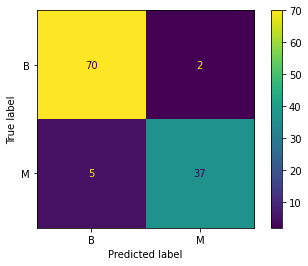

In [27]:
# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, yhat)

_____

## Exercício 1

Para praticarmos e para comparar também, repita o mesmo procedimento com uma Árvore de Decisão (DT) e com uma Floresta Aleatória (RF). Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros para cada modelo - utilizando a estrutura do Pipeline conforme mostramos
    - hiperparâmetros da DT: *criterion* ['gini', 'entropy', 'log_loss'], *max_depth* [5, 10, 15, 20], *splitter* ['best', 'random']
    - hiperparâmetros da RF: *n_estimators* [20, 50, 100, 200, 500], *max_depth* = DT, *criterion* = DT
- compare os resultados obtidos entre si e também com os resultados da regressão logística

### Decision Tree Classifier

In [28]:
# construir o pipeline
steps = [('scaler', StandardScaler()), 
         ('model', DecisionTreeClassifier(random_state = 42))]
pipe = Pipeline(steps)

# construir o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(f1_score, pos_label = 'M')

# construir um dicionário de parâmetros
param_dict = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10, 15, 20],
    'model__splitter': ['best', 'random']
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__criterion=log_loss, model__max_depth=5, model__splitter=best
[CV 1/10; 1/10] END model__criterion=log_loss, model__max_depth=5, model__splitter=best;, score=0.941 total time=   0.0s
[CV 2/10; 1/10] START model__criterion=log_loss, model__max_depth=5, model__splitter=best
[CV 2/10; 1/10] END model__criterion=log_loss, model__max_depth=5, model__splitter=best;, score=0.839 total time=   0.0s
[CV 3/10; 1/10] START model__criterion=log_loss, model__max_depth=5, model__splitter=best
[CV 3/10; 1/10] END model__criterion=log_loss, model__max_depth=5, model__splitter=best;, score=0.882 total time=   0.0s
[CV 4/10; 1/10] START model__criterion=log_loss, model__max_depth=5, model__splitter=best
[CV 4/10; 1/10] END model__criterion=log_loss, model__max_depth=5, model__splitter=best;, score=1.000 total time=   0.0s
[CV 5/10; 1/10] START model__criterion=log_loss, model__max_depth=5, model__splitter=best
[CV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [5, 10, 15, 20],
                                        'model__splitter': ['best', 'random']},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [30]:
print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica Média:')
print(rs_cv.best_score_)

Melhores Parâmetros:
{'model__splitter': 'random', 'model__max_depth': 5, 'model__criterion': 'log_loss'}
Melhor Métrica Média:
0.9192129275952805


In [31]:
# analisando o melhor modelo
# construindo o pipeline
steps = [('scaler', StandardScaler()), 
         ('model', DecisionTreeClassifier(splitter='random',
                                          max_depth = 5,
                                          criterion = 'log_loss',
                                          random_state = 42))]
pipe = Pipeline(steps)
best_model = pipe.fit(x_train, y_train)

# realizando predições
yhat = pipe.predict(x_test)

              precision    recall  f1-score   support

           B       0.97      0.97      0.97        72
           M       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



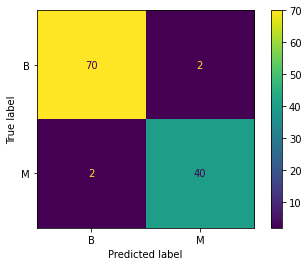

In [32]:
# relatório de classificação
print(classification_report(y_test, yhat))

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, yhat)

### Random Forest

In [33]:
# construir o pipeline
steps = [('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(random_state = 42))]
pipe = Pipeline(steps)

# construir o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# criando a métrica "adaptada"
score = make_scorer(f1_score, pos_label = 'M')

# construir um dicionário de parâmetros
param_dict = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10, 15, 20],
    'model__n_estimators': [20, 50, 100, 200, 500]
}

# criar o objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dict, scoring = score, cv = cvs, verbose = 10)
rs_cv.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 1/10; 1/10] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=1.000 total time=   0.3s
[CV 2/10; 1/10] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 2/10; 1/10] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=0.875 total time=   0.3s
[CV 3/10; 1/10] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 3/10; 1/10] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=1.000 total time=   0.3s
[CV 4/10; 1/10] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV 4/10; 1/10] END model__criterion=gini, model__max_depth=20, model__n_estimators=200;, score=1.000 total time=   0.3s
[CV 5/10; 1/10] START model__criterion=gini, model__max_depth=20, model__n_estimators=200
[CV

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': [5, 10, 15, 20],
                                        'model__n_estimators': [20, 50, 100,
                                                                200, 500]},
                   scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [34]:
print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica Média:')
print(rs_cv.best_score_)

Melhores Parâmetros:
{'model__n_estimators': 100, 'model__max_depth': 5, 'model__criterion': 'entropy'}
Melhor Métrica Média:
0.9611245861981157


In [35]:
# analisando o melhor modelo
# construindo o pipeline
steps = [('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(max_depth = 5,
                                          criterion = 'entropy',
                                          n_estimators = 100,
                                          random_state = 42))]
pipe = Pipeline(steps)
best_model = pipe.fit(x_train, y_train)

# realizando predições
yhat = pipe.predict(x_test)

              precision    recall  f1-score   support

           B       0.95      1.00      0.97        72
           M       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



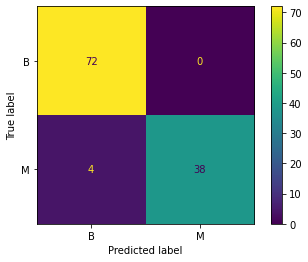

In [41]:
# relatório de classificação
print(classification_report(y_test, yhat))

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, yhat)

_____

A classe `RandomizedSearchCV` apresenta vários atributos interessantes que podem ser manipulados, com maior detalhe no [LINK](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Dentre os principais podemos citar algumas:
- `param_distributions`: podemos aqui especificar uma distribuição estatística para gerar valores aleatórios ao invés de uma lista simples. Isso nos permite explorar situações e maiores espaços de busca de forma mais simples
- `n_iter`: aqui podemos controlar quantas amostras aleatórias serão realizadas. Temos de pensar no *trade-off* entre confiabilidade estatística vs custo computacional
- `n_jobs`: relativo à paralelização dos cálculos. Ajuda do aumento da velocidade da execução do algoritmo
- `refit`: se colocamos True, então ele vai ajustar um modelo final com os melhores parâmetros o que acelera nosso trabalho.

In [42]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from scipy.stats import norm

In [43]:
# realizando a leitura dos dados
data = pd.read_csv('WineQT.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [44]:
# eliminando coluna Id
data.drop(['Id'], axis = 1, inplace = True)

# separando entre preditores e targets
x = data.drop(['quality'], axis = 1)
y = data[['quality']]

# separando o conjunto de validação final
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                random_state=42, stratify=y)

In [45]:
# construindo o pipeline
steps = [('scaler', StandardScaler()), ('model', Lasso())]
pipe = Pipeline(steps)

# construindo o amostrador dos folds
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# construindo um dicionário de DISTRIBUIÇÕES
param_dists = {
    'model__alpha': norm(loc = 1, scale = 0.5)
}

# objeto selecionador
rs_cv = RandomizedSearchCV(pipe, param_dists, scoring='r2', cv=cvs, 
                        verbose = 10, n_iter=100, refit = True, n_jobs=-1)
rs_cv.fit(x_train, y_train)

print('Melhores Parâmetros:')
print(rs_cv.best_params_)
print('Melhor Métrica:')
print(rs_cv.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Melhores Parâmetros:
{'model__alpha': 0.1654656601008011}
Melhor Métrica:
0.2547449867251126


In [46]:
# analisando o melhor estimador
print(rs_cv.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.1654656601008011))])


In [49]:
%%timeit
# realizando novas estimativas
yhat = rs_cv.best_estimator_.predict(x_test)

1.03 ms ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


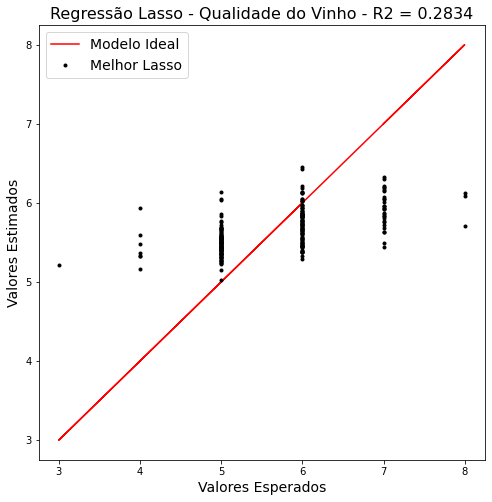

In [48]:
# gráfico com as predições
plt.figure(figsize=(8,8))
plt.plot(y_test, y_test, 'r-', label = 'Modelo Ideal')
plt.plot(y_test, yhat, 'k.', label = 'Melhor Lasso')
plt.xlabel('Valores Esperados', size=  14)
plt.ylabel('Valores Estimados', size = 14)
plt.title(f'Regressão Lasso - Qualidade do Vinho - R2 = {round(r2_score(y_test, yhat),4)}', size = 16)
plt.legend(loc = 'best', prop = {'size': 14})
plt.show()

_____

## Exercício 2

Para praticarmos e para comparar também, repita o mesmo procedimento com um KNN. Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros - utilizando a estrutura do Pipeline conforme mostramos
     - use uma distribuição uniforme para o valor de *k* entre 1 e 100
- compare os resultados obtidos entre si e também com os resultados da regressão linear

_____

## Exercício 3

Para praticarmos e para comparar também, repita o mesmo procedimento com uma floresta aleatória Para isso:

- carregue o conjunto de dados
- separe um conjunto de validação final
- aplique a busca aleatória com os hiperparâmetros adequados para cada modelo - escolha três hiperparâmetros  - utilizando a estrutura do Pipeline conforme mostramos
   - use distribuições uniformes para o número de árvores e para a profundidade máxima
- aplique uma busca em Grade com muitos parâmetros para tentar encontrar o mesmo resultado.
- compare os resultados obtidos entre si